## Traditional machine learning
Feature(s): 'SMILES' column

- Copolymer sequence of A and B monomer
- Binary encoding

Target: y_bin

- Binary class

In [78]:
import sys
import os
from sklearn.model_selection import cross_val_score
from sklearn.base import clone


# Append the parent directory of your package to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', '..')))

In [79]:
import pandas as pd
import numpy as np
import zipfile

path_to_dataset = 'train_polymers.csv'
csv_filename = 'train_polymers.csv'

# Open the file, Correct the encoding and sep if necessary
if path_to_dataset.endswith('.zip'):
    with zipfile.ZipFile(path_to_dataset, 'r') as z:
        # Open the CSV file within the ZIP file
        with z.open(csv_filename) as f:
            # Read the CSV file into a DataFrame
            df = pd.read_csv(f, sep=',', on_bad_lines='warn', index_col = 0)
else:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(path_to_dataset, sep=',', on_bad_lines='warn', index_col = 0)


print('Count of unique smiles:', df.SMILES.unique().shape[0])
print('Count of all of the smiles:', df.shape[0])


Count of unique smiles: 16000
Count of all of the smiles: 16000


In [80]:
# Define mapping
mapping = {'A': 0, 'B': 1}

# Apply mapping and convert sequences to arrays
def encode_sequence(sequence):
    return np.array([mapping[char] for char in sequence.split()])

df['Encoded'] = df['SMILES'].apply(encode_sequence)

In [81]:
display(df.head(5))

,SMILES,y,y_bin,Encoded
0,B B B B A A B B B A B A B B B A B B B B,7.759848,0,"[1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, ..."
1,B B B A A A B B A A B A B A B B B A B B,8.133042,0,"[1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, ..."
2,A A B B A B B A B A B B B B A B B B B B,7.717979,0,"[0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, ..."
3,B B B A B A A A A B A B A B A B B B B B,8.147355,0,"[1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, ..."
4,B B B B B B A B B A B B B B B B B B B A,7.603120,0,"[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, ..."


In [82]:
from MLPipeline import MLmodel, BinTheTarget

Target = ['y_bin']
Features = ['Encoded']
Feature_types = ['numerical']
input = df[:7000]

In [83]:
def objective(trial, model_instance):
    """
    Objective function for Optuna to minimize.
    """
    # Define hyperparameters to tune
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_categorical('max_depth', [None, 10, 20, 30, 40]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 6),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }

    # Clone the model to ensure a fresh instance each trial
    model_clone = clone(model_instance.model)
    model_clone.set_params(**params)
    
    # Define the score metric
    scoring = 'accuracy'

    # Perform cross-validation
    scores = cross_val_score(model_clone, model_instance.X_train, model_instance.y_train, cv=model_instance.cv, scoring=scoring)

    # Return the average score across all folds
    return scores.mean()

In [84]:
from sklearn.metrics import f1_score, cohen_kappa_score, accuracy_score

def train_test(modeltype = 'RandomForestClassifier', target = None, train_size = 50):
    summary = {}

    model = MLmodel(modelType=modeltype, 
                df=df,
                train_count = train_size,
                test_count = 50, 
                target=target, 
                features=Features, 
                hyperparameter_tuning=False,
                feature_types=Feature_types,
                optimization_method='optuna', 
                objective=lambda trial: objective(trial, model)
                )
    
    model.train()
    predictions = model.predict()
    model.evaluate()

    summary['modeltype'] = modeltype
    summary['target'] = target
    summary['train_size'] = train_size
    summary['trues'] = model.y_test
    summary['preds'] = predictions
    summary['model_params'] = model.model.get_params()

    summary['accuracy'] = accuracy_score(model.y_test, predictions)
    summary['f1_micro'] = f1_score(model.y_test, predictions, average='micro')
    summary['f1_macro'] = f1_score(model.y_test, predictions, average='macro')
    summary['kappa'] = cohen_kappa_score(model.y_test, predictions)

    return summary
    

   
MODELS = ['RandomForestClassifier', 'XGBClassifier']
TARGETS = [['y_bin']] #why list?
TRAIN_SIZES = [25, 50, 100, 200]

all_res = []
for model in MODELS:
    for target in TARGETS:
        for train_size in TRAIN_SIZES:
            print(f'RUN: {model} / {target} / {train_size}')
            res = train_test(modeltype = model, target = target, train_size =train_size)
            all_res.append(res)


2024-09-16 16:38:55.346 | INFO     | MLPipeline:__post_init__:134 - ndim y_train: 1
2024-09-16 16:38:55.347 | INFO     | MLPipeline:__post_init__:135 - ndim x_train: 2
2024-09-16 16:38:55.347 | INFO     | MLPipeline:__post_init__:136 - shape y_train: (25,)
2024-09-16 16:38:55.347 | INFO     | MLPipeline:__post_init__:137 - shape x_train: (25, 20)
2024-09-16 16:38:55.416 | INFO     | MLPipeline:__post_init__:134 - ndim y_train: 1
2024-09-16 16:38:55.416 | INFO     | MLPipeline:__post_init__:135 - ndim x_train: 2
2024-09-16 16:38:55.417 | INFO     | MLPipeline:__post_init__:136 - shape y_train: (50,)
2024-09-16 16:38:55.417 | INFO     | MLPipeline:__post_init__:137 - shape x_train: (50, 20)
2024-09-16 16:38:55.481 | INFO     | MLPipeline:__post_init__:134 - ndim y_train: 1
2024-09-16 16:38:55.481 | INFO     | MLPipeline:__post_init__:135 - ndim x_train: 2
2024-09-16 16:38:55.482 | INFO     | MLPipeline:__post_init__:136 - shape y_train: (100,)
2024-09-16 16:38:55.482 | INFO     | MLPipel

RUN: RandomForestClassifier / ['y_bin'] / 25
RandomForestClassifier model trained successfully.
Accuracy for RandomForestClassifier: 0.76
RUN: RandomForestClassifier / ['y_bin'] / 50
RandomForestClassifier model trained successfully.
Accuracy for RandomForestClassifier: 0.78
RUN: RandomForestClassifier / ['y_bin'] / 100
RandomForestClassifier model trained successfully.
Accuracy for RandomForestClassifier: 0.82


2024-09-16 16:38:55.549 | INFO     | MLPipeline:__post_init__:134 - ndim y_train: 1
2024-09-16 16:38:55.549 | INFO     | MLPipeline:__post_init__:135 - ndim x_train: 2
2024-09-16 16:38:55.549 | INFO     | MLPipeline:__post_init__:136 - shape y_train: (200,)
2024-09-16 16:38:55.550 | INFO     | MLPipeline:__post_init__:137 - shape x_train: (200, 20)
2024-09-16 16:38:55.619 | INFO     | MLPipeline:__post_init__:134 - ndim y_train: 1
2024-09-16 16:38:55.619 | INFO     | MLPipeline:__post_init__:135 - ndim x_train: 2
2024-09-16 16:38:55.620 | INFO     | MLPipeline:__post_init__:136 - shape y_train: (25,)
2024-09-16 16:38:55.620 | INFO     | MLPipeline:__post_init__:137 - shape x_train: (25, 20)
2024-09-16 16:38:55.651 | INFO     | MLPipeline:__post_init__:134 - ndim y_train: 1
2024-09-16 16:38:55.651 | INFO     | MLPipeline:__post_init__:135 - ndim x_train: 2
2024-09-16 16:38:55.652 | INFO     | MLPipeline:__post_init__:136 - shape y_train: (50,)
2024-09-16 16:38:55.652 | INFO     | MLPipe

RUN: RandomForestClassifier / ['y_bin'] / 200
RandomForestClassifier model trained successfully.
Accuracy for RandomForestClassifier: 0.86
RUN: XGBClassifier / ['y_bin'] / 25
XGBClassifier model trained successfully.
Accuracy for XGBClassifier: 0.68
RUN: XGBClassifier / ['y_bin'] / 50
XGBClassifier model trained successfully.
Accuracy for XGBClassifier: 0.72
RUN: XGBClassifier / ['y_bin'] / 100
XGBClassifier model trained successfully.
Accuracy for XGBClassifier: 0.88
RUN: XGBClassifier / ['y_bin'] / 200


2024-09-16 16:38:55.740 | INFO     | MLPipeline:__post_init__:134 - ndim y_train: 1
2024-09-16 16:38:55.740 | INFO     | MLPipeline:__post_init__:135 - ndim x_train: 2
2024-09-16 16:38:55.741 | INFO     | MLPipeline:__post_init__:136 - shape y_train: (200,)
2024-09-16 16:38:55.742 | INFO     | MLPipeline:__post_init__:137 - shape x_train: (200, 20)


XGBClassifier model trained successfully.
Accuracy for XGBClassifier: 0.84


In [85]:
print(all_res)

[{'modeltype': 'RandomForestClassifier', 'target': ['y_bin'], 'train_size': 25, 'trues': array([1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1]), 'preds': array([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0]), 'model_params': {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}, 'accuracy': 0.76, 'f1_micro': 0.76, 'f1_macro': 0.7536945812807881, 'kappa': 0.52}, {'modeltype': 'RandomForestClassifier', 'target': ['y_bin'], '

In [86]:
df = pd.DataFrame(all_res)
display(df)

,modeltype,target,train_size,trues,preds,model_params,accuracy,f1_micro,f1_macro,kappa
0,RandomForestClassifier,[y_bin],25,"[1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, ...","[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.76,0.76,0.753695,0.52
1,RandomForestClassifier,[y_bin],50,"[1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.78,0.78,0.772633,0.56
2,RandomForestClassifier,[y_bin],100,"[1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, ...","[1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.82,0.82,0.816401,0.64
3,RandomForestClassifier,[y_bin],200,"[1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, ...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.86,0.86,0.858586,0.72
4,XGBClassifier,[y_bin],25,"[1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, ...","[0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, ...","{'objective': 'binary:logistic', 'use_label_en...",0.68,0.68,0.679487,0.36
5,XGBClassifier,[y_bin],50,"[1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, ...","[1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, ...","{'objective': 'binary:logistic', 'use_label_en...",0.72,0.72,0.718196,0.44
6,XGBClassifier,[y_bin],100,"[1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, ...","[1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, ...","{'objective': 'binary:logistic', 'use_label_en...",0.88,0.88,0.878247,0.76
7,XGBClassifier,[y_bin],200,"[1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, ...","{'objective': 'binary:logistic', 'use_label_en...",0.84,0.84,0.838969,0.68


In [87]:
import matplotlib.pyplot as plt

Text(0.5, 0.98, 'Random Forrest - AdE polymers')

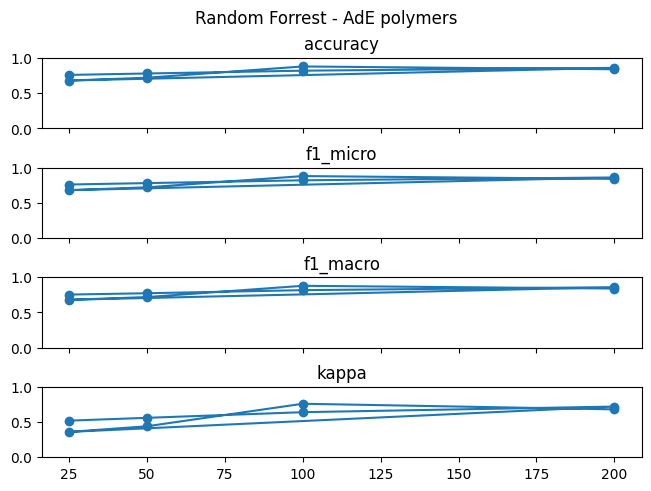

In [88]:
METRICS = ['accuracy','f1_micro','f1_macro', 'kappa']
fig, ax = plt.subplots(len(METRICS), 1, sharex=True, layout = 'constrained')
ax = ax.flatten()

for i, metric in enumerate(METRICS):
    ax[i].plot(df['train_size'], df[metric], marker = 'o')
    ax[i].set_title(metric)
    ax[i].set_ylim(0,1)

fig.suptitle('Random Forrest - AdE polymers')